## submit jobs to cluster

In [2]:
import os
from rosemary import jpt_in_notebook, jpt_setup; jpt_setup()
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

first_N = None
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

####
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; normalize_embeddings = True

dataset = 'wizardlm'
## 
clustering_fn_list = []
clustering_fn_list += [
    f'cl=kmeans_nc={n_clusters}' for n_clusters in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
]

# first_N = 10_000
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'


###

cmds = []
for clustering_fn in clustering_fn_list:
    save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
                f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
                f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

    cmd = f"""
    python note_pruning_clustering.py \
        --model_name {model_name} \
        --dataset {dataset} \
        --encode_fn_type {encode_fn_type} \
        --clustering_fn {clustering_fn} \
        {'--normalize_embeddings' if normalize_embeddings else ''} \
        {'--first_N '+str(first_N) if first_N else ''} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'cluster.{dataset}.{clustering_fn}', 
        nodes=1,
        num_cpus=64,
        cpu_mem=128,
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    cmds.append(cmd)
    
print(f'#cmds: {len(cmds)}')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=100",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=100 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=100

Submiting job with:
{
    "job_name": "cluster.wizardlm.cl=kmeans_nc=200",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 128,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning_clustering.py --model_name all-mpnet-base-v2 --dataset wizardlm --encode_fn_type input --clustering_fn cl=kmeans_nc=200 --normalize_embeddings --save_dir /gpfs/u/home/PTFM/PTFMqngp/

In [8]:

with open('note_pruning_cluster_test.sh', 'w') as f:
    f.write('\n'.join(['CUDA_VISIBLE_DEVICES=1 '+x for x in cmds]))
    
    

## analyze clustering results

In [3]:
save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
            f"clustering/{encode_fn_type+'/' if encode_fn_type!='sft' else ''}{model_name}/"
            f"{dataset+'(N='+str(first_N)+')' if first_N else dataset}/{clustering_fn}")

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
from note_pruning_analysis import get_clustering_results, flatten_dict

dataset='wizardlm'
model_name='all-mpnet-base-v2'

clustering_fn_list = [
    f'cl=kmeans_nc={x}' for x in np.arange(100,1100,100)
]

data = []
for clustering_fn in clustering_fn_list:
    d = get_clustering_results(dataset, model_name, clustering_fn, encode_fn_type='input', return_data=False)
    d = flatten_dict(d['info'])
    d['clustering_fn'] = clustering_fn
    data.append(d)
df = pd.DataFrame(data)
df

,N,dataset,model_name,encode_fn_type,clustering_fn,time_elapsed,scores_inertia,scores_silhouette_score_cd,scores_silhouette_score_l2,scores_variance_ratio,scores_davies_bouldin_index,cluster_sizes
0,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=100,60.689804,103413.578125,0.048134,0.026396,365.340982,4.025689,"[4568, 2483, 2451, 2335, 2335, 2273, 2225, 209..."
1,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=200,118.462425,97995.406250,0.052644,0.028973,231.342594,3.800602,"[2214, 1815, 1488, 1311, 1184, 1152, 1142, 110..."
2,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=300,181.542408,95021.117188,0.050809,0.028066,173.617905,3.805517,"[1496, 1051, 1050, 989, 873, 869, 836, 826, 80..."
3,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=400,235.506032,92827.187500,0.051093,0.028394,141.533127,3.769780,"[1021, 974, 936, 771, 770, 719, 714, 711, 703,..."
4,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=500,293.279377,91202.343750,0.047746,0.026746,120.192785,3.762911,"[1009, 619, 618, 607, 599, 591, 582, 577, 563,..."
5,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=600,343.029895,89824.242188,0.045546,0.025630,105.239384,3.733365,"[780, 589, 553, 547, 542, 531, 513, 508, 503, ..."
6,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=700,412.114341,88644.125000,0.044336,0.025064,94.030267,3.713852,"[621, 535, 517, 517, 497, 460, 459, 455, 453, ..."
7,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=800,467.429262,87672.070312,0.040416,0.023116,85.088616,3.677603,"[599, 531, 500, 443, 439, 419, 419, 412, 412, ..."
8,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=900,510.865212,86785.187500,0.039351,0.022565,77.958307,3.645864,"[553, 464, 425, 424, 424, 412, 394, 390, 372, ..."
9,143000,dataset,all-mpnet-base-v2,input,cl=kmeans_nc=1000,582.222886,85996.101562,0.036810,0.021326,72.052770,3.630483,"[466, 422, 362, 349, 342, 339, 324, 314, 311, ..."


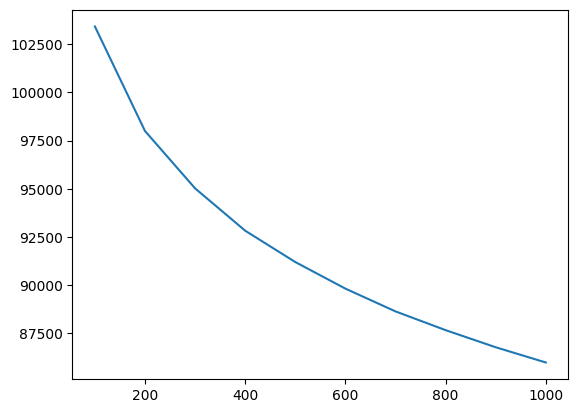

In [298]:


xs = df['clustering_fn'].apply(lambda x: int(x.split('nc=')[-1]))
ys = df['scores_inertia'].to_numpy()
plt.plot(xs, ys)

# ys = df['scores_silhouette_score_cd'].to_numpy()
# plt.plot(xs, ys)
# ys = df['scores_silhouette_score_l2'].to_numpy()
# plt.plot(xs, ys)


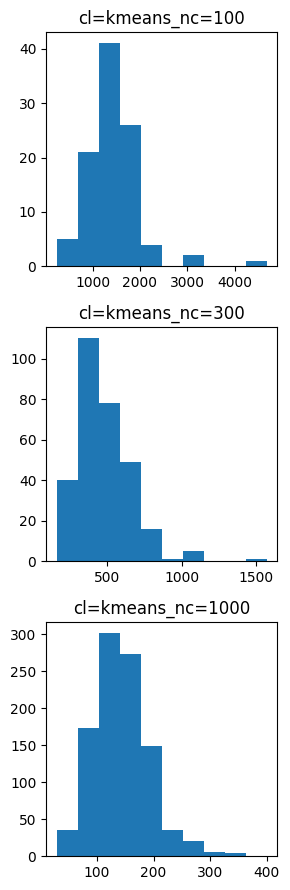

In [8]:
ys_list = df['cluster_sizes'].tolist()
N = len(ys_list)

fig, axs = plt.subplots(N,1,figsize=(3,3*N), sharex=False)
for i in range(N):
    ys = ys_list[i]
    ax = axs[i]
    ax.hist(ys)
    ax.set_title(df.iloc[i]['clustering_fn'])
fig.tight_layout()

## clustering code base


In [9]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
# !nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['0']
0


In [10]:
import re
import argparse
import json
import pickle
import string
import time
import matplotlib.pyplot as plt

import numpy as np
import scipy
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

import time
from note_pruning_analysis import (
    get_lm_output,
    get_dataset,
)
from note_pruning_clustering import (
    pairwise_cosine_distance,
    clustering_sort_by_cluster_size,
    clustering_algorithm_scores,
    clustering_dist_to_centroids,
    clustering_knn_withincluster,
    clustering_run,
    clustering_compute_and_save_results,
)


In [210]:
model_name = 'all-mpnet-base-v2'

dataset = 'wizardlm'
encode_fn_type = 'input'
# first_N = 10_000
first_N = None

n_clusters = 200
clustering_fn = f'cl=kmeans_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}'
# clustering_fn = f'cl=kmeansminibatch_nc={n_clusters}_bsz=256'

In [303]:

dist = 'cd'

# clustering_fn = f''

sort_by = f'semdedup_cl=kmeans_dist=cd_emb=text+embedding_nc={n_clusters}'


if sort_by.startswith('semdedup'):
    clustering_fn = sort_by.split('semdedup_')[-1]
    
    match = re.search(r'dist=([^_]+)', sort_by)
    dist = match.group(1)
    assert(dist in ['cd', 'l2'])
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1))
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    X = d[embed_type]
    X = X / np.linalg.norm(X, axis=-1, keepdims=True) # always normalize
    
    print(f'Running {clustering_fn} {{ {embed_type} }} to compute {"euclidean" if dist == "l2" else "cosine"} '
          'pairwise distance in each cluster.')
    Y, C, clustering_model = clustering_run(clustering_fn, X)
    print('Apply SemDeDup to discard duplicates.')
    S = semdedup(X, Y, dist=dist, device='cuda')

    


Running cl=kmeans_dist=cd_emb=text+embedding_nc=200 { text_embedding } to compute cosine pairwise distance in each cluster.
Apply SemDeDup to discard duplicates.


In [211]:
save_dir = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn+'_test')
os.makedirs(save_dir, exist_ok=True)
save_dir

'clustering/input/all-mpnet-base-v2/wizardlm/cl=kmeans_nc=200_test'

In [212]:

ds = get_dataset(dataset, processed=True)
if encode_fn_type == 'input':
    def get_user_prompt_fn(example):
        example['text'] = example['messages'][0]['content']
        return example
    ds = ds.map(get_user_prompt_fn, num_proc=16)

ds

Dataset({
    features: ['dataset', 'id', 'messages', 'text'],
    num_rows: 143000
})

In [213]:
d = get_lm_output(dataset, 
                  model_name, 
                  encode_fn_type=encode_fn_type,
                  return_text_embedding=True,)
X = d['text_embedding']
X = X / np.linalg.norm(X, axis=-1, keepdims=True)

if first_N:
    ds = ds.select(range(first_N))
    X = X[:first_N]

In [214]:

info = {}
info['N'] = len(X)
info['dataset'] = 'dataset'
info['model_name'] = model_name
info['encode_fn_type'] = encode_fn_type

t0 = time.time()
Y, C, clustering_model = clustering_run(clustering_fn, X)
info['time_elapsed'] = time.time()-t0
info['scores'] = {}
info['scores'].update({'inertia': clustering_model.inertia_})
info['scores'].update(clustering_algorithm_scores(X, Y))
info['cluster_sizes'] = np.unique(Y, return_counts=True)[1].tolist()
with open(os.path.join(save_dir, 'info.json'), 'w') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)
clustering_compute_and_save_results(X, Y, C, ds=ds, save_dir=save_dir)


Initialization complete
Iteration 0, inertia 163252.875.
Iteration 1, inertia 102949.28125.
Iteration 2, inertia 100838.4765625.
Iteration 3, inertia 99992.359375.
Iteration 4, inertia 99495.1328125.
Iteration 5, inertia 99178.5234375.
Iteration 6, inertia 98963.46875.
Iteration 7, inertia 98812.765625.
Iteration 8, inertia 98698.921875.
Iteration 9, inertia 98610.5703125.
Iteration 10, inertia 98540.78125.
Iteration 11, inertia 98489.71875.
Iteration 12, inertia 98453.9609375.
Iteration 13, inertia 98427.546875.
Iteration 14, inertia 98407.0546875.
Iteration 15, inertia 98390.71875.
Iteration 16, inertia 98375.1484375.
Iteration 17, inertia 98360.0703125.
Iteration 18, inertia 98344.2734375.
Iteration 19, inertia 98329.5859375.
Iteration 20, inertia 98315.4453125.
Iteration 21, inertia 98303.09375.
Iteration 22, inertia 98293.34375.
Iteration 23, inertia 98285.1328125.
Iteration 24, inertia 98277.609375.
Iteration 25, inertia 98270.984375.
Iteration 26, inertia 98264.78125.
Iteration 

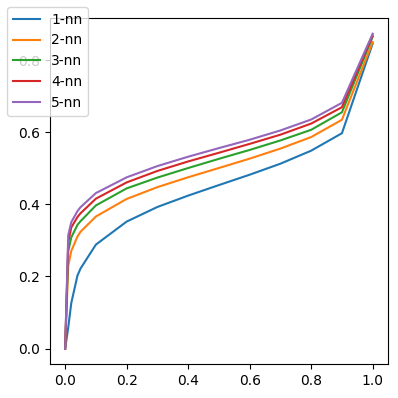

In [96]:
# # torch.quantile(knn_dist, .5, dim=0)

# xs = [0,0.01,0.02,0.02,0.04,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

# fig, ax = plt.subplots(1,1,figsize=(4,4))
# for i in range(5):
#     ys = [np.quantile(knn_dist[:,i], x) for x in xs]
#     ax.plot(xs, ys, label=f'{i+1}-nn')
# fig.legend(loc='upper left')
# fig.tight_layout()


In [22]:
# X = torch.from_numpy(X).float()

In [292]:
from note_pruning_clustering import get_dist_fn, semdedup


    

S = semdedup(X, Y, dist=dist, device='cuda')





brute force compute scores for semdedup. max step length = 1395


In [293]:
S

array([1100., 1100., 1100., ...,  606.,  537.,   83.])

In [250]:
len(eps_list)

1100

51 Can you suggest a list of local businesses or professionals who primarily rely on lead generation to generate sales, while also ensuring that they have a website that is optimized for mobile devices? Examples include real estate agents, plumbers, roofing companies, chiropractors, and dentists. Please provide only the names and do not provide any further information or definitions.
52 What is the historical and cultural background behind the decision to use square boxes for pizza packaging, and how does it compare and contrast with other shapes?
53 How would you go about coding a game for a Discord server that requires a deck of cards (excluding jokers) and 2 to 8 players? The game has multiple rounds with the first round starting with a randomly chosen player announcing a valid poker hand, and subsequent players either announcing a greater poker hand or calling the previous player a liar. If a player calls a liar, all players reveal their cards and determine if the last poker hand a

In [244]:
S

array([1000., 1000., 1000., ...,  549.,  512.,  144.])

In [289]:
l = np.array([len(x) for x in inds_list])
print(f'brute force compute scores for semdedup. max step length {max(np.abs(l[:-1]-l[1:]))}')

brute force compute scores for semdedup. max step length 1395


(array([11., 10., 10., 11., 11., 38., 55., 31., 13., 10.]),
 array([0.        , 0.155979  , 0.311958  , 0.467937  , 0.62391601,
        0.77989501, 0.93587401, 1.09185301, 1.24783201, 1.40381101,
        1.55979002]),
 <BarContainer object of 10 artists>)

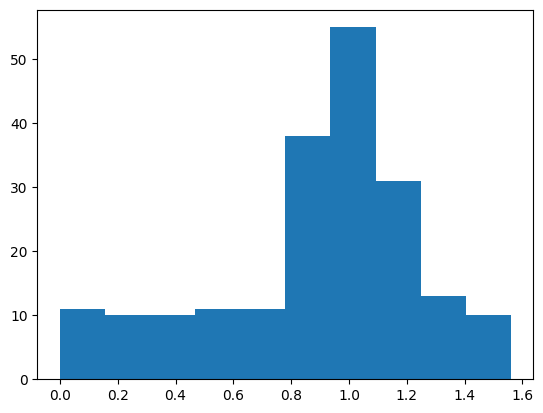

In [177]:

where f=find_subset

D is univariate r.v. with a certain empirical distribution
goal is to sample ϵ s.t. P[D>=ϵ] becomes uniform



(array([   0,  503,  832, 1135, 1411, 1676, 1941, 2194, 2443, 2690, 2935,
        3176, 3417, 3655, 3882, 4105, 4323, 4535, 4745, 4955, 5163, 5371,
        5577, 5776, 5970, 6164, 6357, 6546, 6732, 6918, 7100, 7280, 7456,
        7630, 7800, 7965, 8128, 8289, 8445, 8594, 8740, 8884, 9024, 9161,
        9297, 9432, 9557, 9672, 9783, 9893]),)

In [151]:
eps = 0.1
inds = find_subset(eps)
len(inds)

9980

(tensor([   inf, 0.9650, 0.8817, 0.8442, 0.7795, 0.8679, 0.8210, 0.8746, 0.8298,
         0.8320, 0.7790, 0.8535, 0.7594, 0.8479, 0.9067, 0.6603, 0.8276, 0.8779,
         0.8484, 0.7858, 0.7998, 0.8183, 0.8907, 0.7273, 0.8002, 0.7168, 0.7510,
         0.8247, 0.8766, 0.7905, 0.8222, 0.6693, 0.8869, 0.8470, 0.8342, 0.7114,
         0.7897, 0.8940, 0.6936, 0.8246, 0.7331, 0.6831, 0.8222, 0.7142, 0.8844,
         0.7860, 0.7586, 0.8356, 0.7820, 0.6300, 0.7186, 0.7619, 0.8333, 0.8067,
         0.6389, 0.7887, 0.8226, 0.8059, 0.8589, 0.7199, 0.7862, 0.7490, 0.6957,
         0.6552, 0.7242, 0.7627, 0.8041, 0.6789, 0.7057, 0.7147, 0.7777, 0.6769,
         0.7597, 0.7237, 0.6304, 0.7620, 0.7660, 0.8574, 0.6946, 0.7534, 0.6553,
         0.7326, 0.6937, 0.8162, 0.7344, 0.7956, 0.6594, 0.7311, 0.7325, 0.6555,
         0.6075, 0.6932, 0.7743, 0.6283, 0.8014, 0.8266, 0.5452, 0.7948, 0.5637,
         0.5239, 0.7527, 0.7470, 0.7032, 0.5970, 0.7377, 0.5834, 0.7605, 0.8290,
         0.6348, 0.7091, 0.7

In [149]:
set(d[0.1]) - set(inds), set(inds) - set(d[0.1])

(set(), set())

In [114]:
for eps in [.1, .2, .3, .4, .5, 1, 2]:
    print(eps, len(set(d[eps])))

def is_subset(s1, s2):
    s1 = set(s1)
    s2 = set(s2)
    return len(s1-s2)==0 and len(s1&s2)==len(s1)


print(is_subset(d[0.2], d[0.1]))
print(is_subset(d[0.3], d[0.2]))
print(is_subset(d[0.4], d[0.3]))

0.1 9980
0.2 9979
0.3 9957
0.4 9927
0.5 9891
1 5018
2 50
True
True
True


In [136]:
d[0.1]

[19,
 41,
 77,
 82,
 102,
 117,
 125,
 133,
 138,
 139,
 148,
 152,
 163,
 170,
 237,
 238,
 248,
 252,
 253,
 269,
 300,
 302,
 320,
 329,
 363,
 368,
 466,
 479,
 529,
 544,
 552,
 560,
 564,
 578,
 579,
 581,
 586,
 605,
 625,
 655,
 714,
 762,
 789,
 799,
 801,
 819,
 823,
 852,
 859,
 898,
 909,
 910,
 914,
 955,
 959,
 1004,
 1031,
 1075,
 1078,
 1095,
 1130,
 1137,
 1144,
 1158,
 1166,
 1185,
 1195,
 1206,
 1234,
 1250,
 1261,
 1277,
 1302,
 1346,
 1384,
 1404,
 1429,
 1445,
 1450,
 1452,
 1474,
 1479,
 1508,
 1534,
 1587,
 1600,
 1610,
 1616,
 1619,
 1635,
 1637,
 1661,
 1668,
 1687,
 1723,
 1756,
 1814,
 1829,
 1885,
 1935,
 1937,
 1963,
 1970,
 1981,
 2003,
 2012,
 2069,
 2076,
 2079,
 2092,
 2095,
 2100,
 2104,
 2120,
 2136,
 2155,
 2168,
 2185,
 2201,
 2212,
 2224,
 2291,
 2295,
 2324,
 2339,
 2374,
 2378,
 2401,
 2411,
 2420,
 2450,
 2468,
 2480,
 2521,
 2529,
 2539,
 2559,
 2566,
 2580,
 2585,
 2623,
 2658,
 2673,
 2684,
 2693,
 2736,
 2797,
 2818,
 2929,
 2969,
 2979,
 3

In [74]:
M, inds_min = torch.min(Di_triu, dim=0)

eps = .5
mask_discard = M <= eps
inds_discard = inds_global[torch.nonzero(mask_discard)].squeeze().tolist()
inds_discard_closest = inds_global[inds_min[mask_discard]].squeeze().tolist()


In [78]:
for i, j in zip(inds_discard, inds_discard_closest):
    print(json.dumps({
        'i': i,
        'j': j,
        'text_i': ds[i]['text'],
        'text_j': ds[j]['text']
    }, indent=4))

{
    "i": 5448,
    "j": 4713,
    "text_i": "How can I improve my game theory optimal (GTO) strategy for playing poker, including but not limited to implementing mixed strategies, understanding range construction and utilizing blockers to gain an advantage?",
    "text_j": "How can I optimize my poker gameplay using GTO tactics by employing advanced strategies such as implementing mixed strategies, understanding range construction, and utilizing blockers to gain a strategic advantage in multiple steps?"
}
{
    "i": 7695,
    "j": 7358,
    "text_i": "In a Rails application that uses Mongoid as an object-document mapper, suppose we have a property model that has a many-to-many association with amenities, and an amenity model that has a one-to-many association with sources. Given a specific amenity ID, how can we construct a query that returns all properties associated with that amenity? Please provide a detailed, multi-step explanation along with code examples.",
    "text_j": "In th

In [75]:
for ind in inds:
    print(ds[ind]['text'])




['How can I improve my game theory optimal (GTO) strategy for playing poker, including but not limited to implementing mixed strategies, understanding range construction and utilizing blockers to gain an advantage?']
['In a Rails application that uses Mongoid as an object-document mapper, suppose we have a property model that has a many-to-many association with amenities, and an amenity model that has a one-to-many association with sources. Given a specific amenity ID, how can we construct a query that returns all properties associated with that amenity? Please provide a detailed, multi-step explanation along with code examples.']
['What distinguishes fine-tuning from embeddings in GPT models? Can you provide specific examples of when each method would be more beneficial?']
['What is the SSH command in Google Cloud with CentOS 7 that enables timed or condition-based rebooting? Specifically, how can one initiate system reboot if CPU usage surpasses 90%, memory usage goes beyond 80%, or 

In [25]:
eps = .1
dist = 'cd'

def in_eps_ball_fn(row):
    
    
    return True

df.apply(in_eps_ball_fn, axis=1)

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Length: 10000, dtype: bool